In [40]:
#6) Training of the 6th
#7) One can clearly see, that 1d cnn surpasses the MLP but not substantially. The 2d cnn on the other hand extracts with the great success the low-level features due to it 2d filters. The dropout as a regularization technique is used as well, which in combination gives the best result in comparison to previous ones. 
#8) The training shows bad results - because the data was shuffled
import tensorflow as tf
import numpy as np
%matplotlib inline  
import matplotlib.pyplot as plt

Xdata = np.load("../data/hw2-train-data.npy")
Ydata = np.load("../data/hw2-train-labels.npy").reshape(-1,1)
print("data shape = ", Xdata.shape)
print("labels shape = ", Ydata.shape)

n = 50000
Xtrn,Ytrn = (Xdata[:n]-np.mean(Xdata[:n]))/np.std(Xdata[:n]),np.squeeze(Ydata[:n])
print(Ytrn[:20])
ntrn,dim = Xtrn.shape
Xval,Yval = (Xdata[n:]-np.mean(Xdata[n:]))/np.std(Xdata[n:]),np.squeeze(Ydata[n:]) 

momentum = 0.9
learning_rate_1 = 0.001
steps = 10
batch = 25
epochs = 10

('data shape = ', (57500, 768))
('labels shape = ', (57500, 1))
[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]


In [14]:
Xdata_2d = np.concatenate((np.zeros([Xdata.shape[0],10]),Xdata,np.zeros([Xdata.shape[0],6])),axis=1).reshape((Xdata.shape[0],28,28))
X_2d_trn = Xdata_2d[:ntrn]
X_2d_val = Xdata_2d[ntrn:]
X_2d_trn.shape

(50000, 28, 28)

In [29]:
# def cnn_2d(X, y, k, l, learning_rate, prob):
    
#     X = tf.expand_dims(X,3)
    
#     for i in range(k):
#         X = tf.layers.conv2d(X, 32 , 5 , padding='same', activation = tf.nn.relu)
#         X = tf.layers.max_pooling2d(X, 3, 2, padding='same')
    
#     X = tf.nn.dropout(X, keep_prob = prob)
#     X = tf.layers.flatten(X)
    
#     for i in range(l):
#         X = tf.layers.dense(X, 100, activation = tf.nn.relu)
#         X = tf.nn.dropout(X, keep_prob = prob)
    
#     logits = tf.layers.dense(X, 10, activation = None)
#     softmax_ = tf.nn.softmax(logits)
    
#     xentropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(y,10, dtype=tf.float32), logits=logits))
#     train_step = tf.train.AdamOptimizer(learning_rate).minimize(xentropy)
#     correct_prediction = tf.equal(tf.argmax(softmax_, 1), tf.cast(y, tf.int64))
#     accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
#     return xentropy, accuracy, train_step

In [51]:
def cnn(X, y, k, l, learning_rate, prob, cnn_dims = 2):
    
    X = tf.expand_dims(X,-1)
    
    for i in range(k):
        if cnn_dims == 2:
            X = tf.layers.conv2d(X, 32 , 5 , padding='same', activation = tf.nn.relu)
            X = tf.layers.max_pooling2d(X, 3, 2, padding='same')
    
    X = tf.nn.dropout(X, keep_prob = prob)
    X = tf.layers.flatten(X)
    
    for i in range(l):
        X = tf.layers.dense(X, 100, activation = tf.nn.relu)
        X = tf.nn.dropout(X, keep_prob = prob)
    
    logits = tf.layers.dense(X, 10, activation = None)
    softmax_ = tf.nn.softmax(logits)
    
    xentropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(y,10, dtype=tf.float32), logits=logits))
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(xentropy)
    correct_prediction = tf.equal(tf.argmax(softmax_, 1), tf.cast(y, tf.int64))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    return xentropy, accuracy, train_step

In [53]:
def stoch(k ,l , Xtrn_ = X_2d_trn, Xval_ = X_2d_val, batch = batch, epochs = epochs, learning_rate = learning_rate_1, momentum = 0.0, only_last = False, optimizer = "None", cnn_dims = 2):
    print("k =",k, "l =",l,"batch =",batch,"learning_rate =",learning_rate,"momentum = ", momentum)
    tf.reset_default_graph()
    
    if cnn_dims == 2:
        X = tf.placeholder(tf.float32, shape=(None, 28, 28), name="X")
    y = tf.placeholder(tf.int32, shape=(None), name="y")
    p = tf.placeholder(tf.float32)
    
    if cnn_dims == 2:
        loss, acc, up = cnn(X, y, k, l, learning_rate, p)
        Xval = Xval_
        Xtrn = Xtrn_
    perms = np.array_split(np.random.permutation(len(Xtrn)),len(Xtrn)/batch)
    init = tf.global_variables_initializer()
    

    with tf.Session() as sess:
        sess.run(init)
        for i in range(epochs):
            for perm in perms:
                if optimizer not in ["adam","gradient"]:
                    loss_train, acc_train, _, _, _ = sess.run([loss,acc,up[0],up[1],up[2]], feed_dict={X: Xtrn[perm], y:Ytrn[perm], p: 0.7})
                else:
                    loss_train, acc_train, _ = sess.run([loss,acc,up], feed_dict={X: Xtrn[perm], y:Ytrn[perm], p: 0.7})
            loss_val, acc_val = sess.run([loss, acc], feed_dict={X: Xval, y:Yval, p: 1.0})
            if only_last == False:
                print("step", i, "loss(train)", loss_train, "loss(val)", loss_val, "accuracy(train)", acc_train, "accuracy(val)", acc_val)
        if only_last == True:
            print("step", i, "loss(train)", loss_train, "loss(val)", loss_val, "accuracy(train)", acc_train, "accuracy(val)", acc_val)


In [31]:
stoch( k = 2, l = 2, optimizer = "adam")

('k =', 2, 'l =', 2, 'batch =', 25, 'learning_rate =', 0.001, 'momentum = ', 0.0)
('step', 0, 'loss(train)', 0.024167834, 'loss(val)', 0.079361379, 'accuracy(train)', 1.0, 'accuracy(val)', 0.97653335)
('step', 1, 'loss(train)', 0.083361149, 'loss(val)', 0.047612771, 'accuracy(train)', 0.95999998, 'accuracy(val)', 0.98746669)
('step', 2, 'loss(train)', 0.24681869, 'loss(val)', 0.045065667, 'accuracy(train)', 0.95999998, 'accuracy(val)', 0.98746669)
('step', 3, 'loss(train)', 0.091708586, 'loss(val)', 0.047707357, 'accuracy(train)', 0.95999998, 'accuracy(val)', 0.98813331)
('step', 4, 'loss(train)', 0.016369686, 'loss(val)', 0.038410164, 'accuracy(train)', 1.0, 'accuracy(val)', 0.98893332)
('step', 5, 'loss(train)', 0.019262256, 'loss(val)', 0.046299364, 'accuracy(train)', 1.0, 'accuracy(val)', 0.98706669)
('step', 6, 'loss(train)', 0.016311958, 'loss(val)', 0.043038089, 'accuracy(train)', 1.0, 'accuracy(val)', 0.98933333)
('step', 7, 'loss(train)', 0.038092036, 'loss(val)', 0.038221214,

In [32]:
stoch( k = 1, l = 3, optimizer = "adam")

('k =', 1, 'l =', 3, 'batch =', 25, 'learning_rate =', 0.001, 'momentum = ', 0.0)
('step', 0, 'loss(train)', 0.07888291, 'loss(val)', 0.099513084, 'accuracy(train)', 1.0, 'accuracy(val)', 0.97373331)
('step', 1, 'loss(train)', 0.099819653, 'loss(val)', 0.07768888, 'accuracy(train)', 0.95999998, 'accuracy(val)', 0.9788)
('step', 2, 'loss(train)', 0.12060907, 'loss(val)', 0.068901576, 'accuracy(train)', 0.95999998, 'accuracy(val)', 0.98026669)
('step', 3, 'loss(train)', 0.10150839, 'loss(val)', 0.064593524, 'accuracy(train)', 0.92000002, 'accuracy(val)', 0.9824)
('step', 4, 'loss(train)', 0.014183727, 'loss(val)', 0.067240559, 'accuracy(train)', 1.0, 'accuracy(val)', 0.98293334)
('step', 5, 'loss(train)', 0.10387339, 'loss(val)', 0.064583041, 'accuracy(train)', 0.95999998, 'accuracy(val)', 0.98373336)
('step', 6, 'loss(train)', 0.0063032862, 'loss(val)', 0.080466561, 'accuracy(train)', 1.0, 'accuracy(val)', 0.97920001)
('step', 7, 'loss(train)', 0.045507971, 'loss(val)', 0.056037795, 'ac

In [33]:
stoch( k = 2, l = 1, optimizer = "adam")

('k =', 2, 'l =', 1, 'batch =', 25, 'learning_rate =', 0.001, 'momentum = ', 0.0)
('step', 0, 'loss(train)', 0.0087662898, 'loss(val)', 0.06645444, 'accuracy(train)', 1.0, 'accuracy(val)', 0.98173332)
('step', 1, 'loss(train)', 0.011216873, 'loss(val)', 0.045711912, 'accuracy(train)', 1.0, 'accuracy(val)', 0.98666668)
('step', 2, 'loss(train)', 0.0041980809, 'loss(val)', 0.042248137, 'accuracy(train)', 1.0, 'accuracy(val)', 0.98853332)
('step', 3, 'loss(train)', 0.032871414, 'loss(val)', 0.044514652, 'accuracy(train)', 1.0, 'accuracy(val)', 0.98680001)
('step', 4, 'loss(train)', 0.001040003, 'loss(val)', 0.039587591, 'accuracy(train)', 1.0, 'accuracy(val)', 0.98866665)
('step', 5, 'loss(train)', 0.015618131, 'loss(val)', 0.041925717, 'accuracy(train)', 1.0, 'accuracy(val)', 0.9892)
('step', 6, 'loss(train)', 0.046669073, 'loss(val)', 0.04724627, 'accuracy(train)', 0.95999998, 'accuracy(val)', 0.98760003)
('step', 7, 'loss(train)', 0.15230976, 'loss(val)', 0.038413953, 'accuracy(train)'

In [47]:
def show_n(n,img_data):
    for i in range(1,n):
        plt.subplot(330+i)
        plt.imshow(img_data[i,:,:])
        plt.title(Ytrn[i])
        plt.axis('off')
    plt.show()

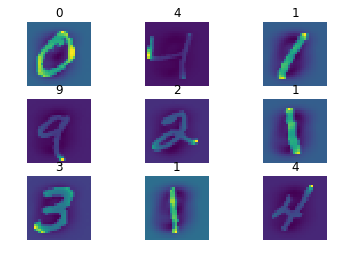

In [48]:
show_n(10,X_2d_trn)

In [46]:
perms = np.random.permutation(768)
XdataP = Xdata[:,perms]
XdataP_2d = np.concatenate((np.zeros([Xdata.shape[0],10]),XdataP,np.zeros([Xdata.shape[0],6])),axis=1).reshape((Xdata.shape[0],28,28))
XP_2d_trn = XdataP_2d[:ntrn]
XP_2d_val = XdataP_2d[ntrn:]

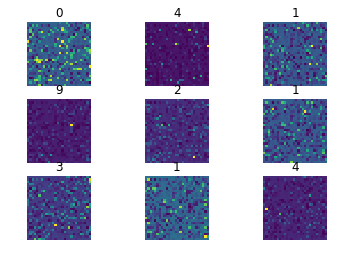

In [49]:
show_n(10,XdataP_2d)

In [54]:
#8) The training shows bad results - because the data was shuffled
stoch(k = 3, l = 1, Xtrn_ = XP_2d_trn, Xval_ = XP_2d_val, optimizer = "adam")

('k =', 3, 'l =', 1, 'batch =', 25, 'learning_rate =', 0.001, 'momentum = ', 0.0)
('step', 0, 'loss(train)', 0.72568178, 'loss(val)', 0.38076138, 'accuracy(train)', 0.72000003, 'accuracy(val)', 0.88053334)
('step', 1, 'loss(train)', 0.48550126, 'loss(val)', 0.3188974, 'accuracy(train)', 0.88, 'accuracy(val)', 0.89786667)
('step', 2, 'loss(train)', 0.33709484, 'loss(val)', 0.27624759, 'accuracy(train)', 0.92000002, 'accuracy(val)', 0.91213334)
('step', 3, 'loss(train)', 0.41411245, 'loss(val)', 0.25973743, 'accuracy(train)', 0.92000002, 'accuracy(val)', 0.91986668)
('step', 4, 'loss(train)', 0.51827627, 'loss(val)', 0.25731933, 'accuracy(train)', 0.88, 'accuracy(val)', 0.92079997)
('step', 5, 'loss(train)', 0.24521802, 'loss(val)', 0.22489564, 'accuracy(train)', 0.92000002, 'accuracy(val)', 0.92946666)
('step', 6, 'loss(train)', 0.29313043, 'loss(val)', 0.23234242, 'accuracy(train)', 0.83999997, 'accuracy(val)', 0.92813331)
('step', 7, 'loss(train)', 0.11925933, 'loss(val)', 0.23128186,